# Empirical Comparison of Three Adaptive Moment Optimization Methods

**E. Bughsn** - MSc in Data Science & Artificial Intelligence, UCA

**Q. Le Roux** - MSc in Data Science & Artificial Intelligence, UCA


## 1. Library Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import tensorflow as tf

from plot_keras_history import plot_history
from tensorflow.keras import Input, Model
from tensorflow.keras.datasets import mnist, fashion_mnist, cifar10
from tensorflow.keras.layers import Flatten, Dense, Concatenate
from tensorflow.keras.layers import Conv2D, SeparableConv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.utils import plot_model
from keras.utils import np_utils

Using TensorFlow backend.


## 2. Custom Function Declarations

In [2]:
def normalize(dataset):
    """
    Normalizes the pixel values of an image stored as an array
    """
    return dataset/255.

def one_hot_labels(labels, depth=10):
    """
    One-hot encodes the imported labels
    """
    return tf.one_hot(labels, depth=depth)

In [3]:
def shallow_neural_network(input_shape, num_classes):
    """
    Creates a shallow neural network
    """
    inputs = Input(shape=input_shape)
    flatten = Flatten()(inputs)
    outputs = Dense(num_classes, activation="softmax")(flatten)
    return Model(inputs, outputs)

In [4]:
def deep_neural_network(input_shape, num_classes):
    """
    Creates a Deep (Fully-Connected) Neural Network
    """
    inputs = Input(shape=input_shape)
    flatten = Flatten()(inputs)
    layer_1 = Dense(64, activation="relu")(flatten)
    layer_2 = Dense(32, activation="relu")(layer_1)
    layer_3 = Dense(16, activation="relu")(layer_2)
    outputs = Dense(num_classes, activation="softmax")(layer_3)
    return Model(inputs, outputs)

In [5]:
def convolutional_neural_network(input_shape, num_classes):
    """
    Creates a convolutional neural network
    """
    inputs = Input(shape=input_shape)
    x = Conv2D(128, 3, padding="same", activation="relu")(inputs)
    x = Conv2D(64, 3, padding="same", activation="relu")(x)
    x = Conv2D(32, 3, padding="same", activation="relu")(x)
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    return Model(inputs, outputs)

In [6]:
def residual_neural_network(input_shape, num_classes):
    """
    Creates a residual neural network
    """
    inputs = Input(shape=input_shape)
    x = Conv2D(128, 3, padding="same", activation="relu")(inputs)
    x = Conv2D(64, 3, padding="same", activation="relu")(x)
    previous_block_activation_1 = x
    previous_block_activation_2 = x
    residual = SeparableConv2D(64, 3, 
                               padding="same", 
                               activation="relu")(previous_block_activation_2)
    x = Concatenate()([x, residual])
    previous_block_activation = x
    residual = SeparableConv2D(64, 3, 
                               padding="same", 
                               activation="relu")(previous_block_activation_1)
    x = Concatenate()([x, residual])
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    return Model(inputs, outputs)

In [7]:
def compile_fit(model, X, y, X_val, y_val,
                optimizer, loss, metrics,
                epochs, batch_size):
    """
    Compiles and fits a model given a set of hyperparameters
    """
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )
    history = model.fit(
        x=X, y=y,
        epochs=epochs, batch_size=batch_size,
        validation_data = (X_val, y_val),
        verbose=0
    )
    return history

In [8]:
def plot_loss(model, dataset):
    """
    Plots a comparative representation of obtained losses for
    a specific model for all three selected optimizers
    """
    if dataset == "MNIST":
        res = results_mnist
    elif dataset == "Fashion-MNIST":
        res = results_fmnist
    elif dataset == "Road":
        res = results_road
    else:
        res = results_cifar
    a = res[f"{model}_adam"].history["loss"]
    b = res[f"{model}_adam"].history["val_loss"]
    c = res[f"{model}_adamw"].history["loss"]
    d = res[f"{model}_adamw"].history["val_loss"]
    e = res[f"{model}_amsgrad"].history["loss"]
    f = res[f"{model}_amsgrad"].history["val_loss"]

    plt.figure(figsize=(12,10))
    plt.plot(a, '--', linewidth=1, color="maroon")
    plt.plot(b, linewidth=3, alpha=0.5, color="firebrick")
    plt.plot(c, '--', linewidth=1, color="lightseagreen")
    plt.plot(d, linewidth=3, alpha=0.5, color="teal")
    plt.plot(e, '--', linewidth=1, color="purple")
    plt.plot(f, linewidth=3, alpha=0.5, color="mediumvioletred")
    plt.xlabel("EPOCHS", fontsize=13)
    plt.ylabel("LOSS VALUE", fontsize=13)
    plt.title("Observed loss values per epoch given " + \
              f"a specific optimizer on the {dataset} dataset",
              fontsize=15)
    plt.legend(["Adam Training Loss", "Adam Testing Loss",
                "AdamW Training Loss", "Adamw Testing Loss",
                "AMSGrad Training Loss", "AMSGrad Testing Loss"],
               fontsize=13)
    plt.show()


## 3. Dataset Imports

### 3.1. MNIST

1. Import dataset
2. Normalize X arrays (features)
3. One-hot encode Y arrays (labels)

In [9]:
(mx_train, my_train), (mx_test, my_test) = mnist.load_data()
mx_train, mx_test = normalize(mx_train), normalize(mx_test)
my_train, my_test = one_hot_labels(my_train), one_hot_labels(my_test)

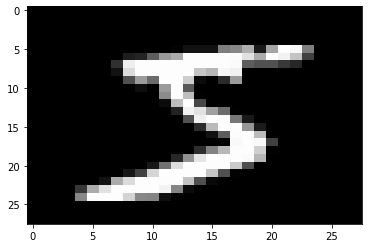

In [10]:
plt.imshow(mx_train[0],aspect="auto",cmap='gray')
plt.show()

### 3.2. Fashion-MNIST

1. Import dataset
2. Normalize X arrays (features)
3. One-hot encode Y arrays (labels)

In [11]:
(fmx_train, fmy_train), (fmx_test, fmy_test) = fashion_mnist.load_data()
fmx_train, fmx_test = normalize(fmx_train), normalize(fmx_test)
fmy_train, fmy_test = one_hot_labels(fmy_train), one_hot_labels(fmy_test)

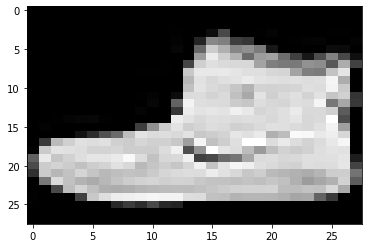

In [12]:
plt.imshow(fmx_train[0],aspect="auto",cmap='gray')
plt.show()

## 4. Model Declarations

In [13]:
# Global variable declaration

input_shape = (28, 28)
input_shape_cnn = (28, 28, 1)
num_classes = 10

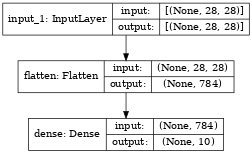

In [14]:
# Declaring Shallow Models
shallow_mnist = shallow_neural_network(input_shape=input_shape, 
                                       num_classes=num_classes)

shallow_fmnist = shallow_neural_network(input_shape=input_shape, 
                                        num_classes=num_classes)

plot_model(shallow_mnist, show_shapes=True, dpi=50)

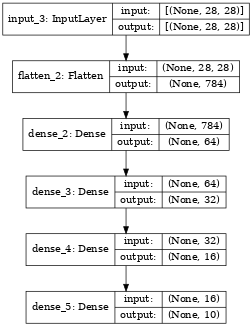

In [15]:
# Declaring Deep (Fully-Connected) Models
dnn_mnist = deep_neural_network(input_shape=input_shape, 
                                num_classes=num_classes)

dnn_fmnist = deep_neural_network(input_shape=input_shape, 
                                 num_classes=num_classes)

plot_model(dnn_mnist, show_shapes=True, dpi=50)

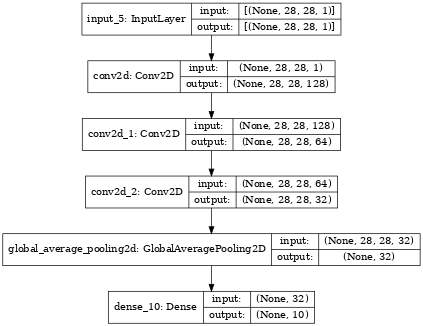

In [16]:
# Declaring Convolutional Models
cnn_mnist = convolutional_neural_network(input_shape=input_shape_cnn, 
                                         num_classes=num_classes)

cnn_fmnist = convolutional_neural_network(input_shape=input_shape_cnn, 
                                          num_classes=num_classes)

plot_model(cnn_mnist, show_shapes=True, dpi=50)

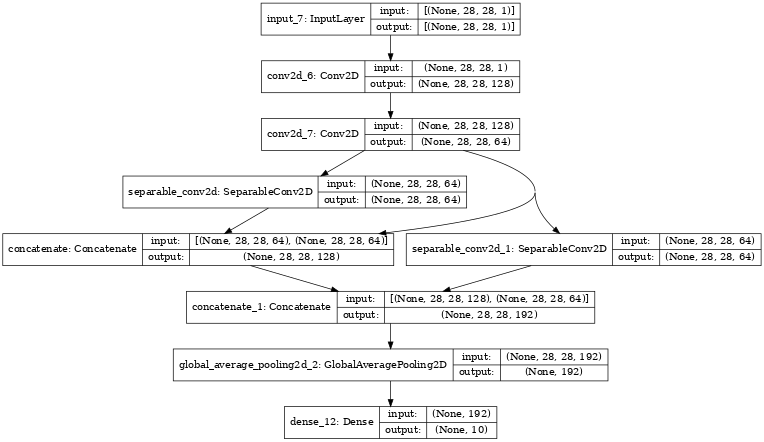

In [17]:
# Declaring ResNet Models
resnet_mnist = residual_neural_network(input_shape=input_shape_cnn, 
                                       num_classes=num_classes)

resnet_fmnist = residual_neural_network(input_shape=input_shape_cnn, 
                                        num_classes=num_classes)

plot_model(resnet_mnist, show_shapes=True, dpi=50)

## 5. Experiments

In [18]:
# Global Variable Declaration
epochs = 100
batch_size = 32
loss = "categorical_crossentropy"
metrics = ["accuracy"]

# Generic learning rate and weight decay for AdamW and AMSgrad
lr=0.001
beta_1=0.9
beta_2=0.999
weight_decay=1e-4
epsilon=1e-8
decay=0.

optimizers = [("adam", Adam()), 
              ("adamw", AdamW(lr=lr, beta_1=beta_1, beta_2=beta_2, 
                              weight_decay=weight_decay, epsilon=epsilon, 
                              decay=decay)), 
              ("amsgrad", AdamW(lr=lr, beta_1=beta_1, beta_2=beta_2, 
                                weight_decay=weight_decay, epsilon=epsilon, 
                                decay=decay,
                                amsgrad=True))]

results_mnist = {}
results_fmnist = {}

### 5.1. Computing loss results for shallow models

#### MNIST

In [19]:
for name, optimizer in optimizers:
    print(f"\n\nComputing losses for Shallow NN with optimizer {name}")
    m = compile_fit(shallow_mnist, 
                    mx_train, my_train, 
                    mx_test, my_test,
                    optimizer, loss, metrics,
                    epochs, batch_size)
    results_mnist[f"shallow_{name}"]=m



Computing losses for Shallow NN with optimizer adam


Computing losses for Shallow NN with optimizer adamw


Computing losses for Shallow NN with optimizer amsgrad


#### Fashion-MNIST

In [20]:
for name, optimizer in optimizers:
    print(f"\n\nComputing losses for Shallow NN with optimizer {name}")
    m = compile_fit(shallow_fmnist, 
                    fmx_train, fmy_train, 
                    fmx_test, fmy_test,
                    optimizer, loss, metrics,
                    epochs, batch_size)
    results_fmnist[f"shallow_{name}"]=m



Computing losses for Shallow NN with optimizer adam


Computing losses for Shallow NN with optimizer adamw


Computing losses for Shallow NN with optimizer amsgrad


### 5.2. Computing loss results for deep (fully-connected) models

#### MNIST

In [21]:
for name, optimizer in optimizers:
    print(f"\n\nComputing losses for Deep NN with optimizer {name}")
    m = compile_fit(dnn_mnist, 
                    mx_train, my_train, 
                    mx_test, my_test,
                    optimizer, loss, metrics,
                    epochs, batch_size)
    results_mnist[f"deep_{name}"]=m



Computing losses for Deep NN with optimizer adam


Computing losses for Deep NN with optimizer adamw


Computing losses for Deep NN with optimizer amsgrad


#### Fashion-MNIST

In [22]:
for name, optimizer in optimizers:
    print(f"\n\nComputing losses for Deep NN with optimizer {name}")
    m = compile_fit(dnn_fmnist, 
                    fmx_train, fmy_train, 
                    fmx_test, fmy_test,
                    optimizer, loss, metrics,
                    epochs, batch_size)
    results_fmnist[f"deep_{name}"]=m



Computing losses for Deep NN with optimizer adam


Computing losses for Deep NN with optimizer adamw


Computing losses for Deep NN with optimizer amsgrad


### 5.3. Computing loss results for convolutional models

#### MNIST

In [23]:
for name, optimizer in optimizers:
    print(f"\n\nComputing losses for CNN with optimizer {name}")
    m = compile_fit(cnn_mnist, 
                    mx_train, my_train, 
                    mx_test, my_test,
                    optimizer, loss, metrics,
                    epochs, batch_size)
    results_mnist[f"cnn_{name}"]=m



Computing losses for CNN with optimizer adam


Computing losses for CNN with optimizer adamw


Computing losses for CNN with optimizer amsgrad


#### Fashion-MNIST

In [24]:
for name, optimizer in optimizers:
    print(f"\n\nComputing losses for CNN with optimizer {name}")
    m = compile_fit(cnn_fmnist, 
                    fmx_train, fmy_train, 
                    fmx_test, fmy_test,
                    optimizer, loss, metrics,
                    epochs, batch_size)
    results_fmnist[f"cnn_{name}"]=m



Computing losses for CNN with optimizer adam


Computing losses for CNN with optimizer adamw


Computing losses for CNN with optimizer amsgrad


### 5.4. Computing loss results for residual models

#### MNIST

In [25]:
for name, optimizer in optimizers:
    print(f"\n\nComputing losses for ResNet with optimizer {name}")
    m = compile_fit(resnet_mnist, 
                    mx_train, my_train, 
                    mx_test, my_test,
                    optimizer, loss, metrics,
                    epochs, batch_size)
    results_mnist[f"resnet_{name}"]=m



Computing losses for ResNet with optimizer adam


Computing losses for ResNet with optimizer adamw


Computing losses for ResNet with optimizer amsgrad


#### Fashion-MNIST

In [26]:
for name, optimizer in optimizers:
    print(f"\n\nComputing losses for ResNet with optimizer {name}")
    m = compile_fit(resnet_fmnist, 
                    fmx_train, fmy_train, 
                    fmx_test, fmy_test,
                    optimizer, loss, metrics,
                    epochs, batch_size)
    results_fmnist[f"resnet_{name}"]=m


\Computing losses for ResNet with optimizer adam

\Computing losses for ResNet with optimizer adamw

\Computing losses for ResNet with optimizer amsgrad


## 6. Result Visualizations

### 6.1 MNIST

#### 6.1.1 Shallow Models

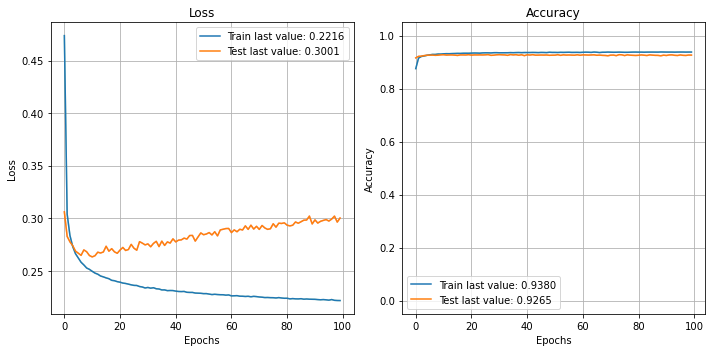

In [27]:
plot_history(results_mnist["shallow_adam"].history)

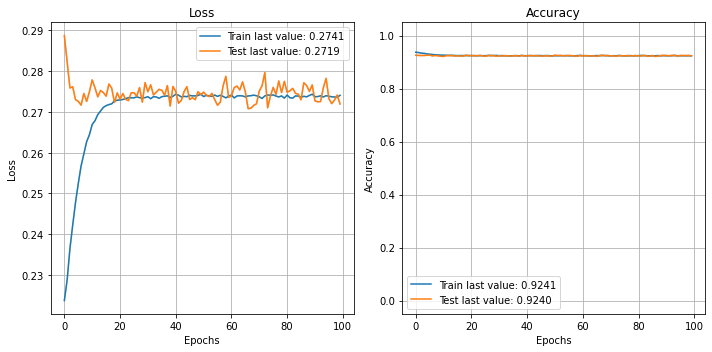

In [28]:
plot_history(results_mnist["shallow_adamw"].history)

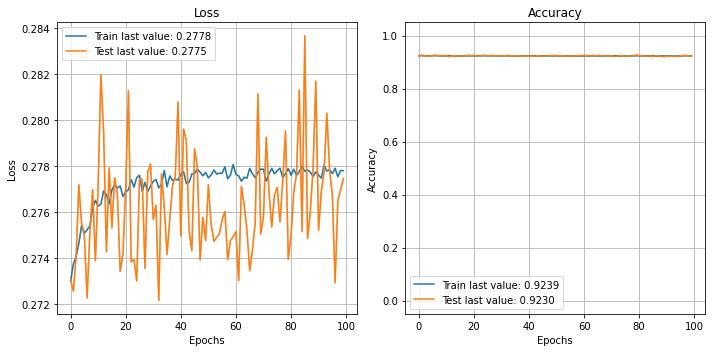

In [29]:
plot_history(results_mnist["shallow_amsgrad"].history)

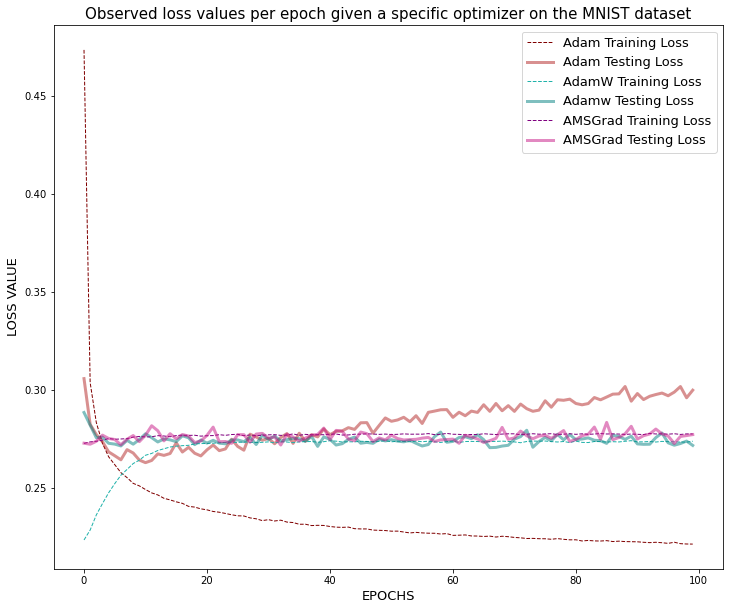

In [30]:
plot_loss("shallow", "MNIST")

#### 6.1.2 Deep (Fully-Connected) Models

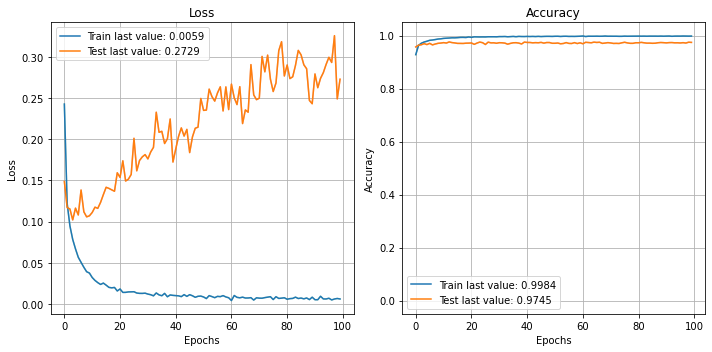

In [31]:
plot_history(results_mnist["deep_adam"].history)

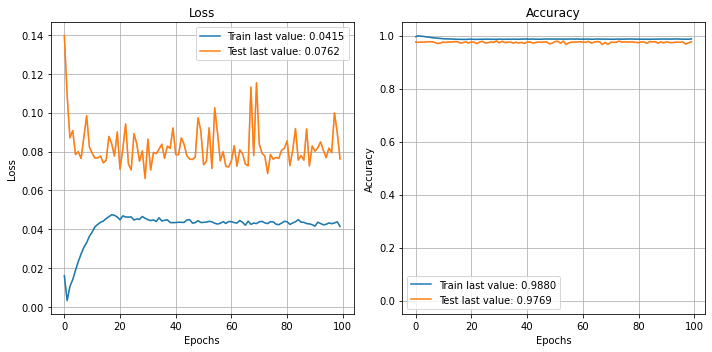

In [32]:
plot_history(results_mnist["deep_adamw"].history)

In [33]:
plot_history(results_mnist["deep_amsgrad"].history)

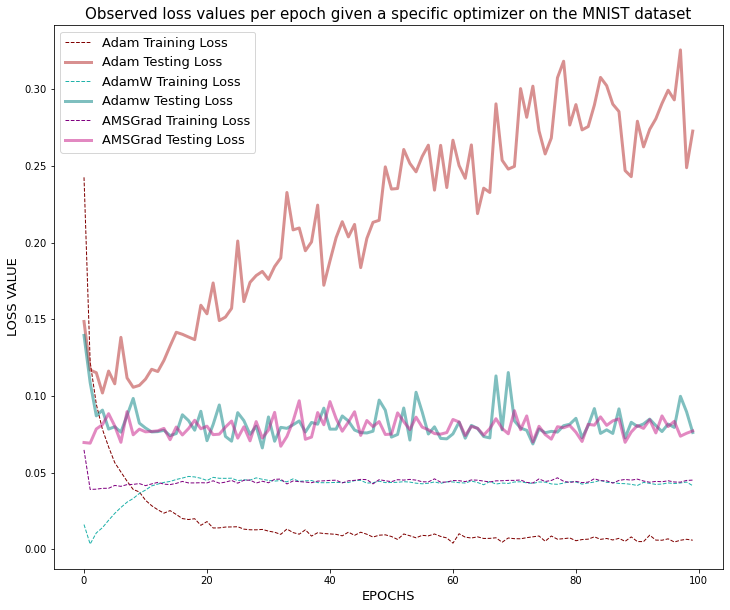

In [34]:
plot_loss("deep", "MNIST")

#### 6.1.3 Convolutional Models

In [35]:
plot_history(results_mnist["cnn_adam"].history)

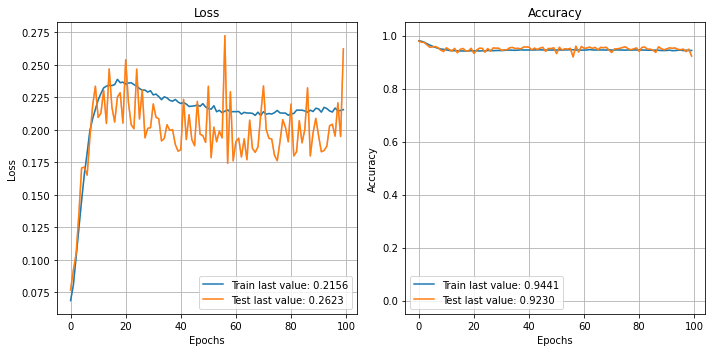

In [36]:
plot_history(results_mnist["cnn_adamw"].history)

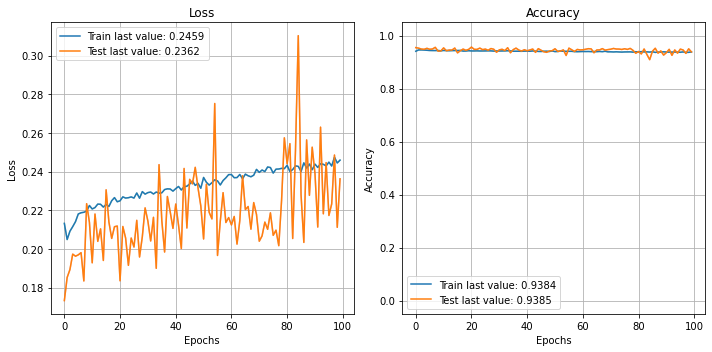

In [37]:
plot_history(results_mnist["cnn_amsgrad"].history)

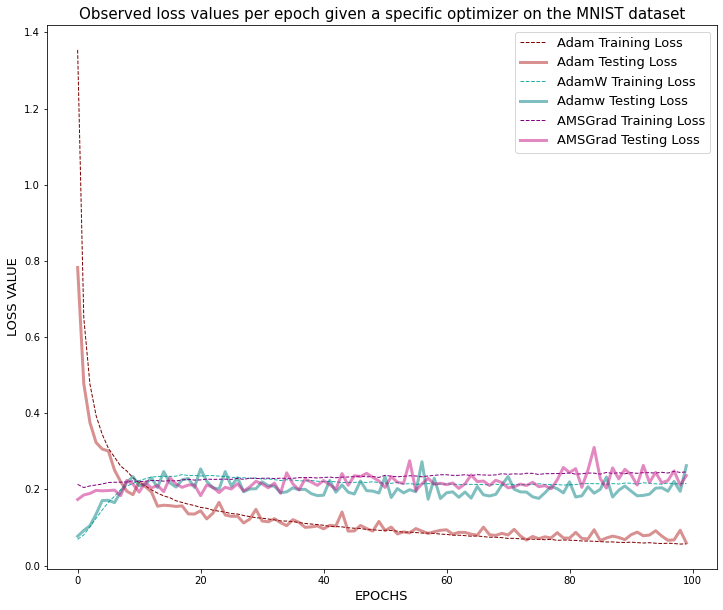

In [38]:
plot_loss("cnn", "MNIST")

#### 6.1.4 Residual Models

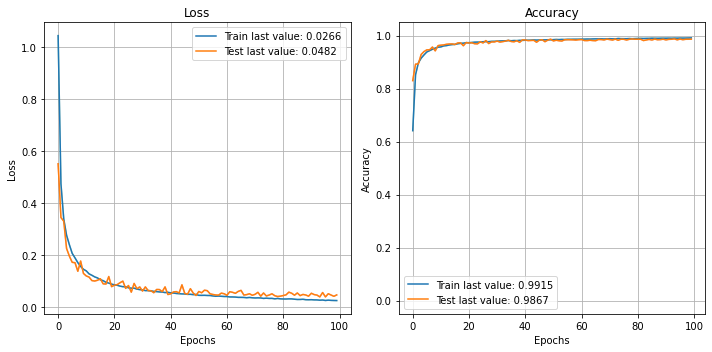

In [39]:
plot_history(results_mnist["resnet_adam"].history)

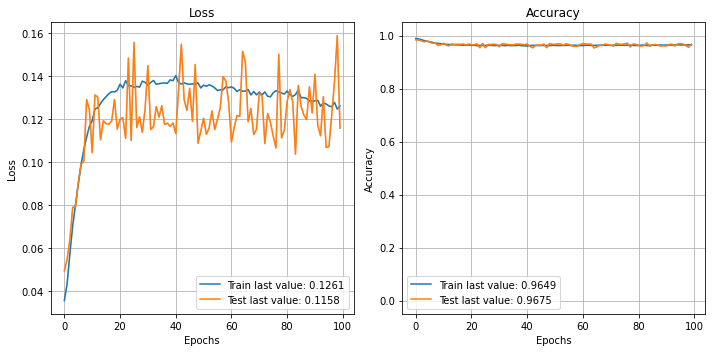

In [40]:
plot_history(results_mnist["resnet_adamw"].history)

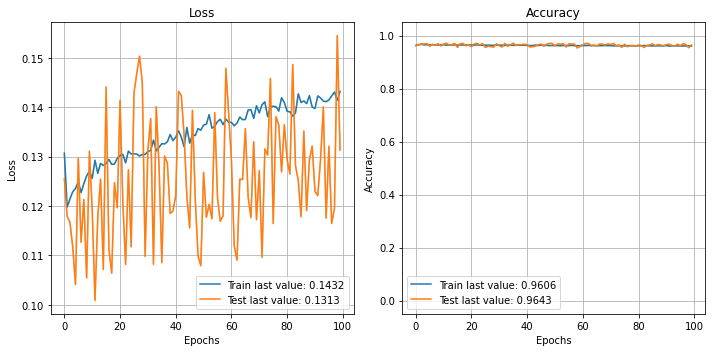

In [41]:
plot_history(results_mnist["resnet_amsgrad"].history)

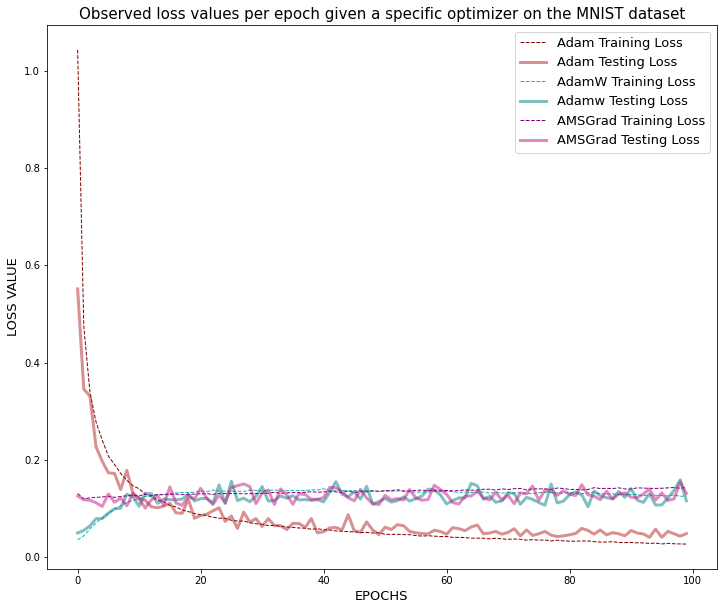

In [42]:
plot_loss("resnet", "MNIST")

### 6.2 Fashion-MNIST


#### 6.2.1 Shallow Models

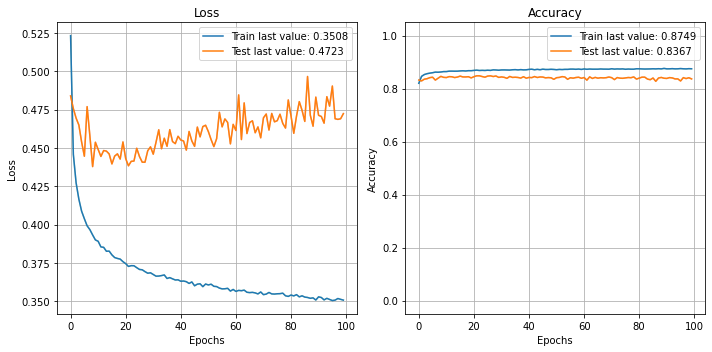

In [43]:
plot_history(results_fmnist["shallow_adam"].history)

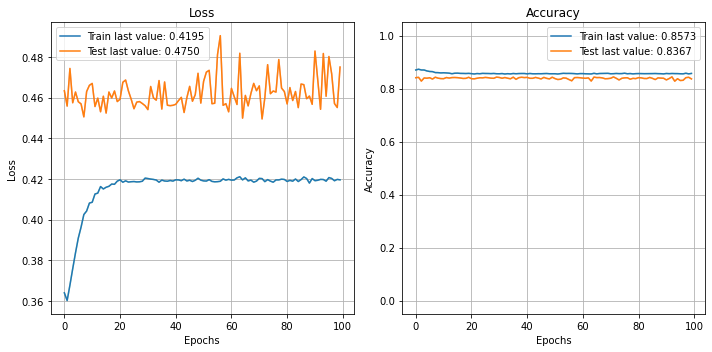

In [44]:
plot_history(results_fmnist["shallow_adamw"].history)

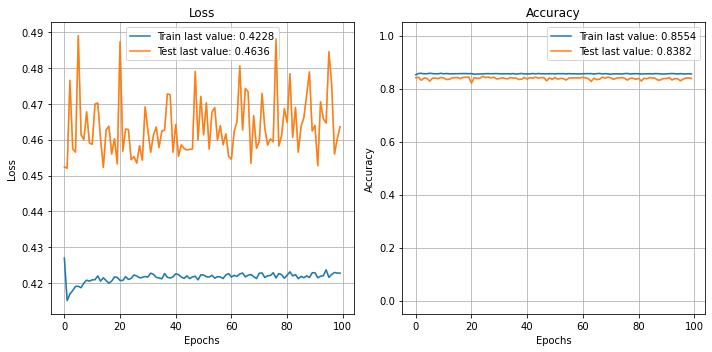

In [45]:
plot_history(results_fmnist["shallow_amsgrad"].history)

In [62]:
plot_loss("shallow", "Fashion-MNIST")

#### 6.1.2 Deep (Fully-Connected) Models

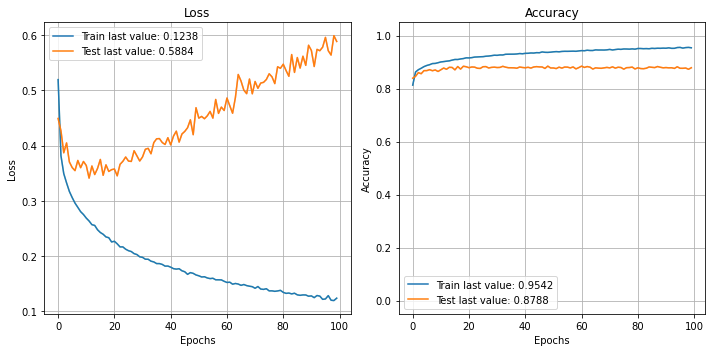

In [47]:
plot_history(results_fmnist["deep_adam"].history)

In [48]:
plot_history(results_fmnist["deep_adamw"].history)

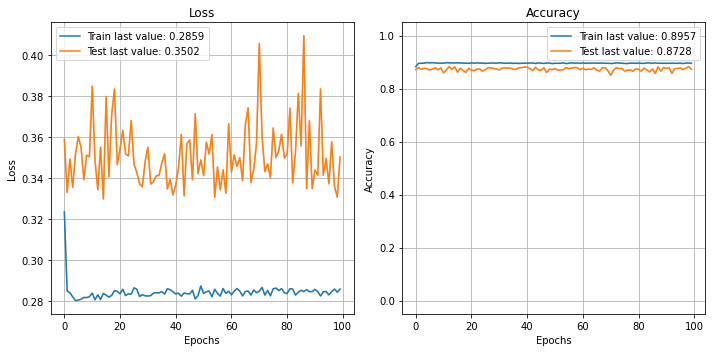

In [49]:
plot_history(results_fmnist["deep_amsgrad"].history)

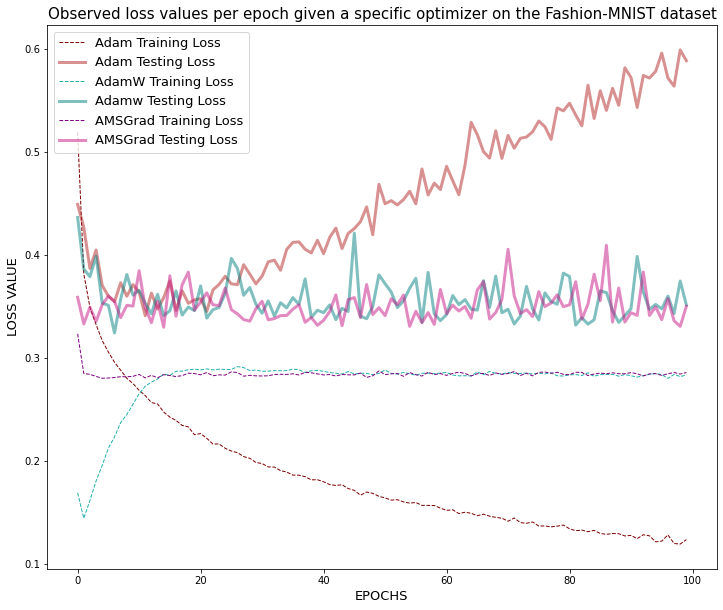

In [63]:
plot_loss("deep", "Fashion-MNIST")

#### 6.1.3 Convolutional Models

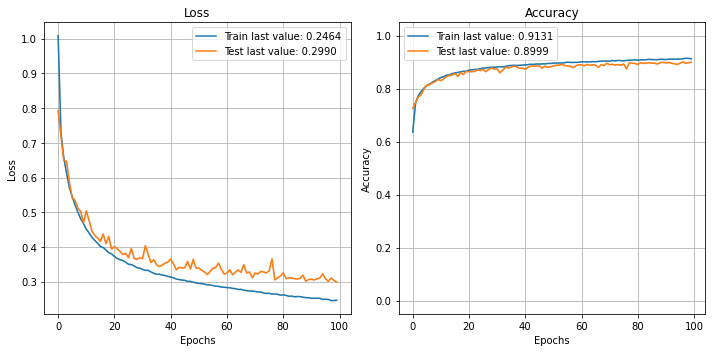

In [51]:
plot_history(results_fmnist["cnn_adam"].history)

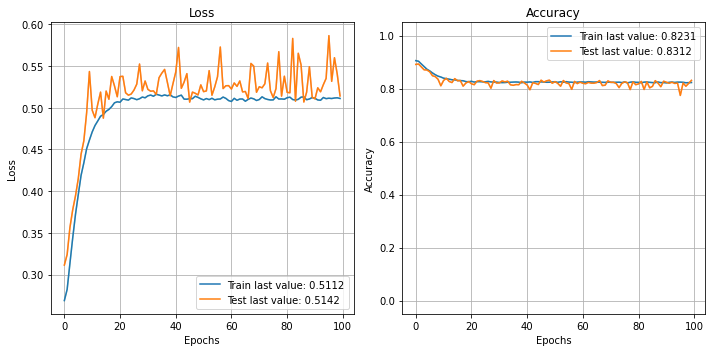

In [52]:
plot_history(results_fmnist["cnn_adamw"].history)

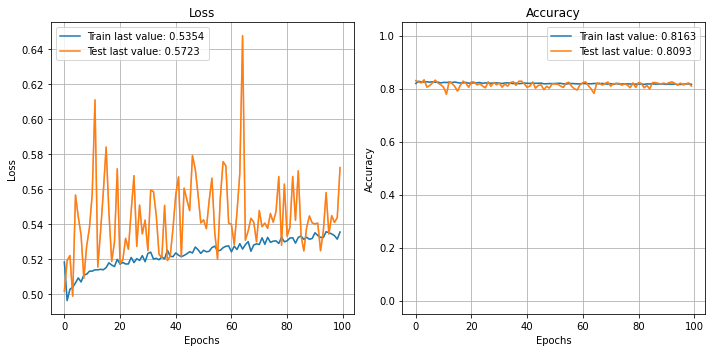

In [53]:
plot_history(results_fmnist["cnn_amsgrad"].history)

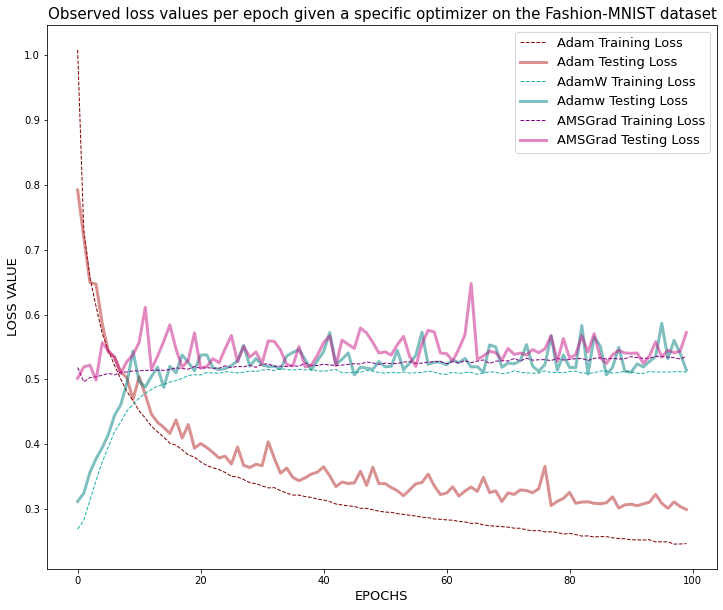

In [64]:
plot_loss("cnn", "Fashion-MNIST")

#### 6.1.4 Residual Models

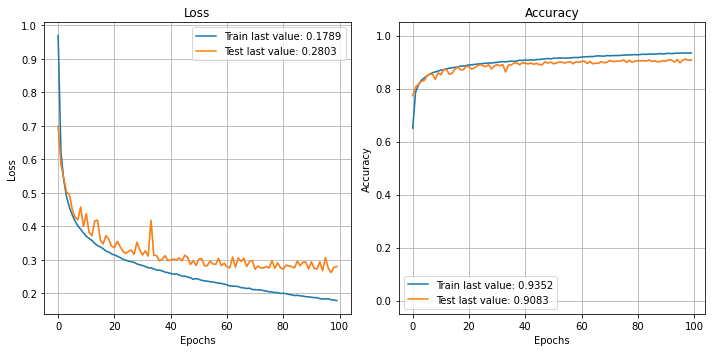

In [55]:
plot_history(results_fmnist["resnet_adam"].history)

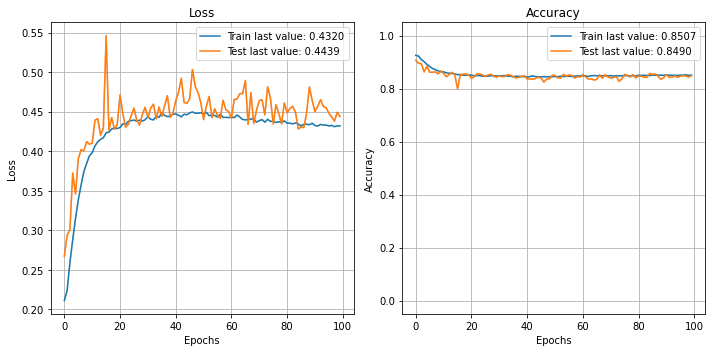

In [56]:
plot_history(results_fmnist["resnet_adamw"].history)

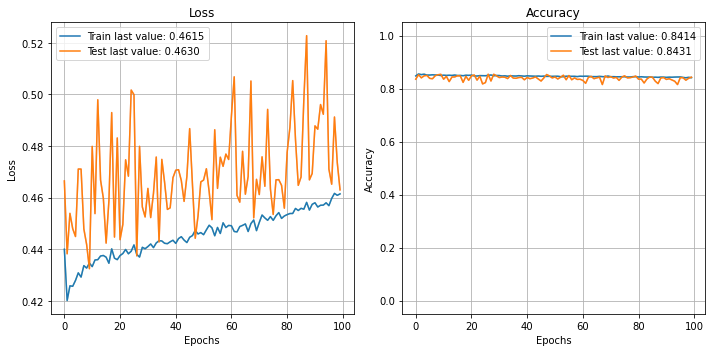

In [57]:
plot_history(results_fmnist["resnet_amsgrad"].history)

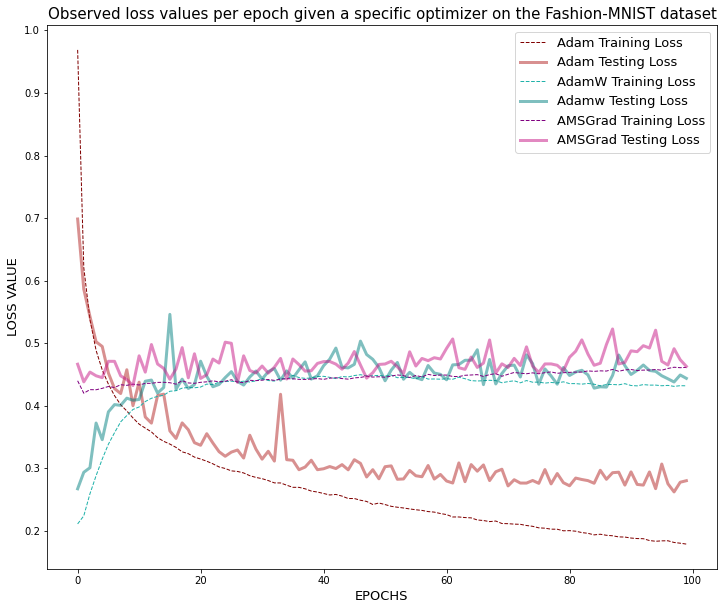

In [65]:
plot_loss("resnet", "Fashion-MNIST")

## 7. Expanding to CIFAR-10

### 7.1 Importing the dataset

In [9]:
# CIFAR-10 import

(cifar_x_train, cifar_y_train), (cifar_x_test, cifar_y_test) = cifar10.load_data()
cifar_x_train, cifar_x_test = normalize(cifar_x_train), normalize(cifar_x_test)
cifar_y_train, cifar_y_test = one_hot_labels(cifar_y_train), one_hot_labels(cifar_y_test)
cifar_y_train = tf.reshape(cifar_y_train, [50000, 10])
cifar_y_test = tf.reshape(cifar_y_test, [10000, 10])

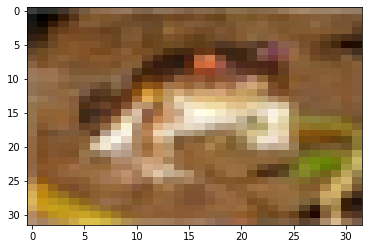

In [10]:
plt.imshow(cifar_x_train[0],aspect="auto",cmap='gray')
plt.show()

## 7.2. Model Declarations

In [11]:
# Global variable declaration

input_shape = (32, 32, 3)
num_classes = 10

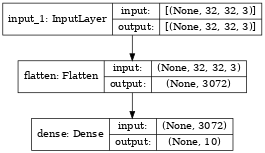

In [12]:
# Declaring Shallow Models
shallow_cifar = shallow_neural_network(input_shape=input_shape, 
                                       num_classes=num_classes)

plot_model(shallow_cifar, show_shapes=True, dpi=50)

In [13]:
# Declaring Deep (Fully-Connected) Models
dnn_cifar = deep_neural_network(input_shape=input_shape, 
                                num_classes=num_classes)

plot_model(dnn_cifar, show_shapes=True, dpi=50)

In [14]:
# Declaring Convolutional Models
cnn_cifar = convolutional_neural_network(input_shape=input_shape, 
                                         num_classes=num_classes)

plot_model(cnn_cifar, show_shapes=True, dpi=50)

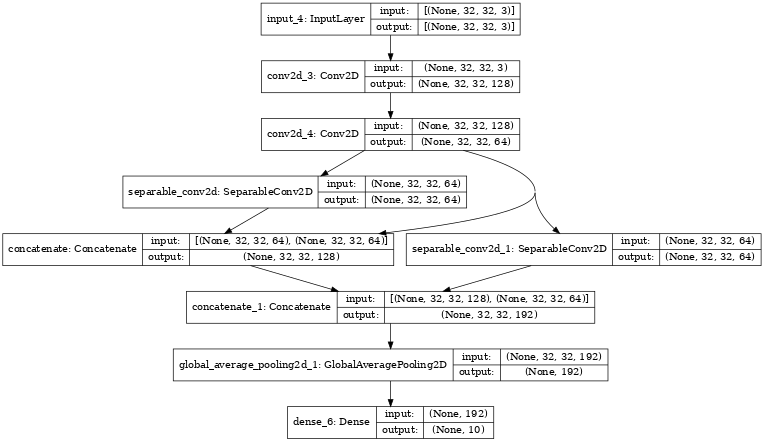

In [15]:
# Declaring ResNet Models
resnet_cifar = residual_neural_network(input_shape=input_shape, 
                                       num_classes=num_classes)

plot_model(resnet_cifar, show_shapes=True, dpi=50)

### 7.3 Computing the Results

In [18]:
# Global Variable Declaration
epochs = 100
batch_size = 32
loss = "categorical_crossentropy"
metrics = ["accuracy"]

# Generic learning rate and weight decay for AdamW and AMSgrad
lr=0.001
beta_1=0.9
beta_2=0.999
weight_decay=1e-4
epsilon=1e-8
decay=0.

optimizers = [("adam", Adam()), 
              ("adamw", AdamW(lr=lr, beta_1=beta_1, beta_2=beta_2, 
                              weight_decay=weight_decay, epsilon=epsilon, 
                              decay=decay)), 
              ("amsgrad", AdamW(lr=lr, beta_1=beta_1, beta_2=beta_2, 
                                weight_decay=weight_decay, epsilon=epsilon, 
                                decay=decay,
                                amsgrad=True))]

results_cifar = {}

#### 7.3.1. Computing loss results for shallow models

In [19]:
for name, optimizer in optimizers:
    print(f"\n\nComputing losses for Shallow NN with optimizer {name}")
    m = compile_fit(shallow_cifar, 
                    cifar_x_train, cifar_y_train, 
                    cifar_x_test, cifar_y_test,
                    optimizer, loss, metrics,
                    epochs, batch_size)
    results_cifar[f"shallow_{name}"]=m



Computing losses for Shallow NN with optimizer adam


Computing losses for Shallow NN with optimizer adamw


Computing losses for Shallow NN with optimizer amsgrad


#### 7.3.2. Computing loss results for deep (fully-connected) models

In [24]:
for name, optimizer in optimizers:
    print(f"\n\nComputing losses for Deep NN with optimizer {name}")
    m = compile_fit(dnn_cifar, 
                    cifar_x_train, cifar_y_train, 
                    cifar_x_test, cifar_y_test,
                    optimizer, loss, metrics,
                    epochs, batch_size)
    results_cifar[f"deep_{name}"]=m



Computing losses for Deep NN with optimizer adam


Computing losses for Deep NN with optimizer adamw


Computing losses for Deep NN with optimizer amsgrad


#### 7.3.3. Computing loss results for convolutional models

In [29]:
for name, optimizer in optimizers:
    print(f"\n\nComputing losses for CNN with optimizer {name}")
    m = compile_fit(cnn_cifar, 
                    cifar_x_train, cifar_y_train, 
                    cifar_x_test, cifar_y_test,
                    optimizer, loss, metrics,
                    epochs, batch_size)
    results_cifar[f"cnn_{name}"]=m



Computing losses for CNN with optimizer adam


Computing losses for CNN with optimizer adamw


Computing losses for CNN with optimizer amsgrad


#### 7.3.4. Computing loss results for residual models

In [34]:
for name, optimizer in optimizers:
    print(f"\n\nComputing losses for ResNet with optimizer {name}")
    m = compile_fit(resnet_cifar, 
                    cifar_x_train, cifar_y_train, 
                    cifar_x_test, cifar_y_test,
                    optimizer, loss, metrics,
                    epochs, batch_size)
    results_cifar[f"resnet_{name}"]=m



Computing losses for ResNet with optimizer adam


Computing losses for ResNet with optimizer adamw


Computing losses for ResNet with optimizer amsgrad


### 7.4. Result Visualizations

#### 7.4.1 Shallow Models

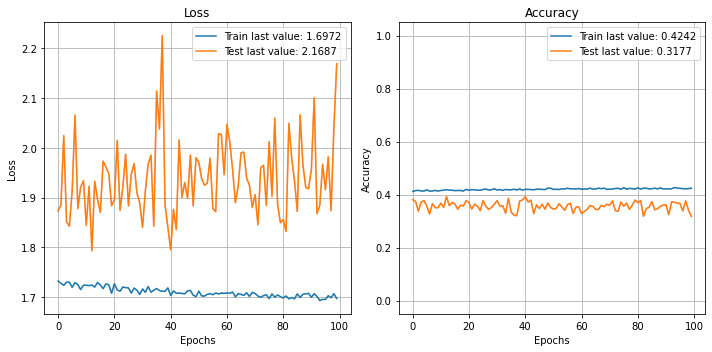

In [20]:
plot_history(results_cifar["shallow_adam"].history)

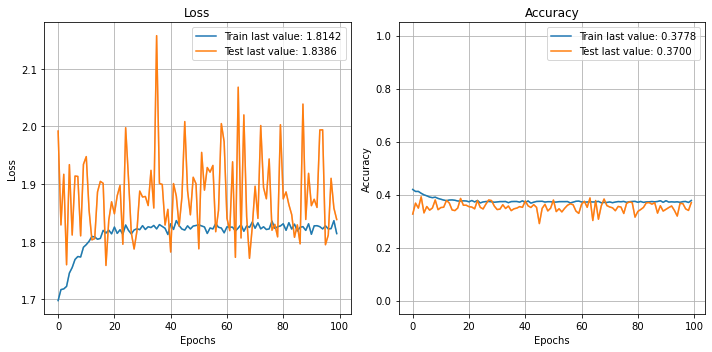

In [21]:
plot_history(results_cifar["shallow_adamw"].history)

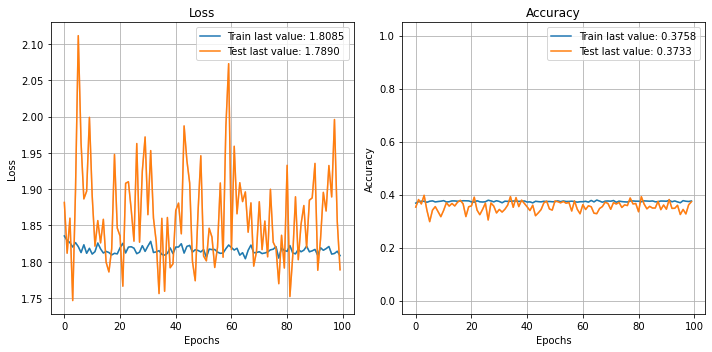

In [22]:
plot_history(results_cifar["shallow_amsgrad"].history)

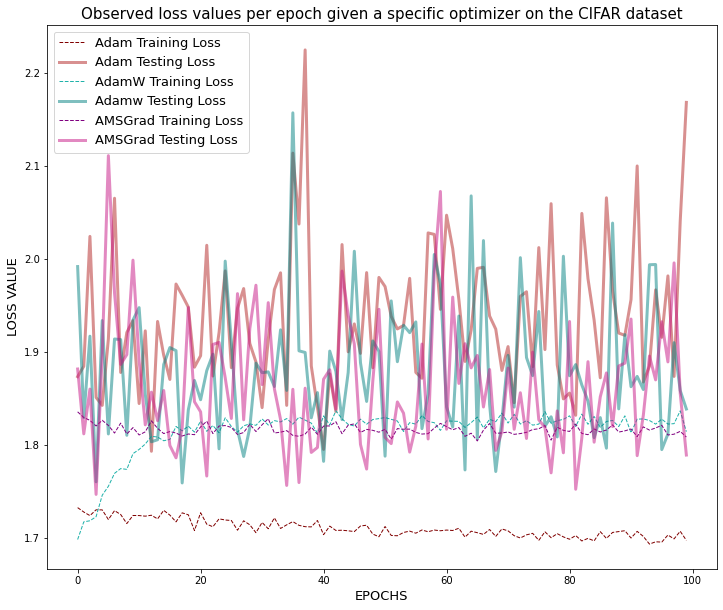

In [23]:
plot_loss("shallow", "CIFAR")

#### 7.4.2 Deep (Fully-Connected) Models

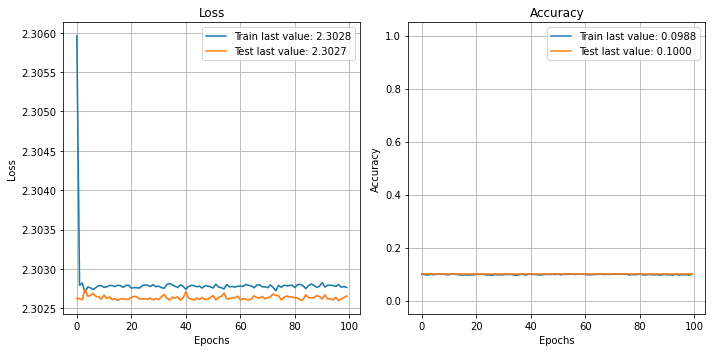

In [25]:
plot_history(results_cifar["deep_adam"].history)

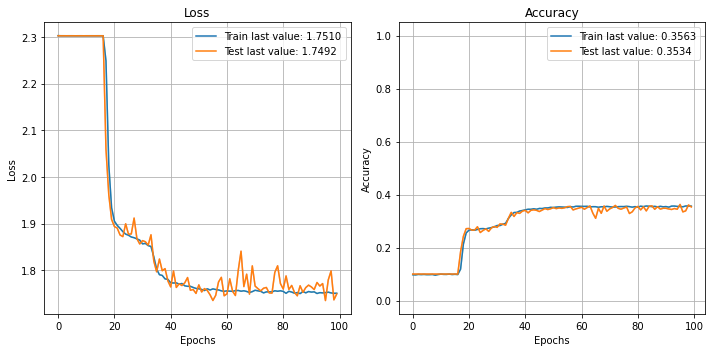

In [26]:
plot_history(results_cifar["deep_adamw"].history)

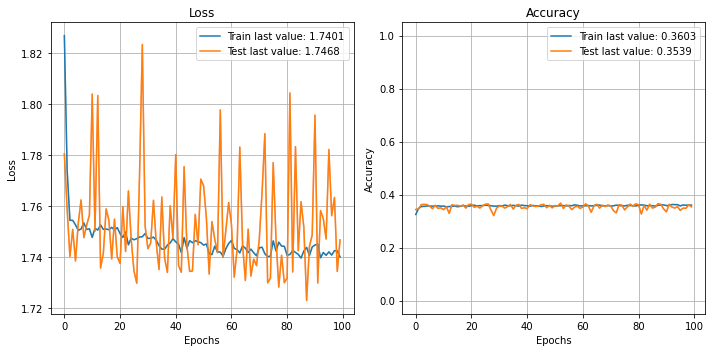

In [27]:
plot_history(results_cifar["deep_amsgrad"].history)

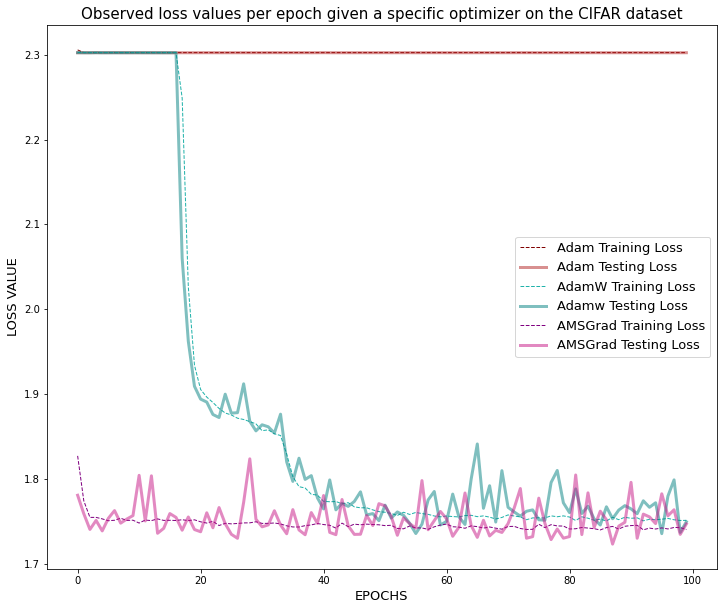

In [28]:
plot_loss("deep", "CIFAR")

#### 7.4.3 Convolutional Models

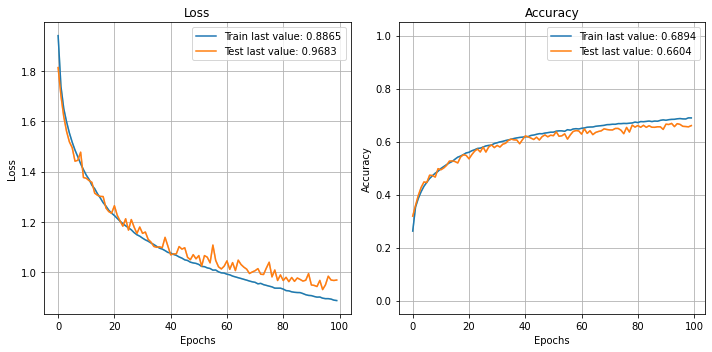

In [30]:
plot_history(results_cifar["cnn_adam"].history)

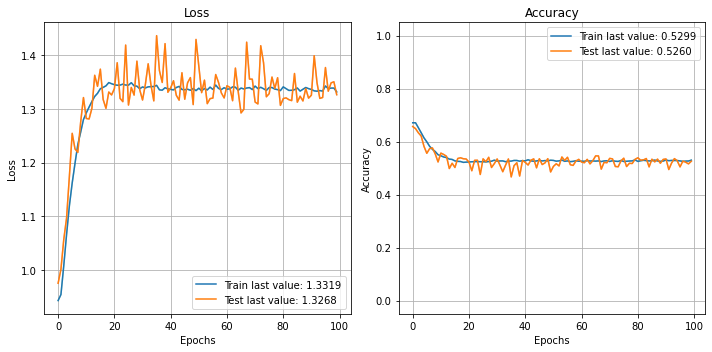

In [31]:
plot_history(results_cifar["cnn_adamw"].history)

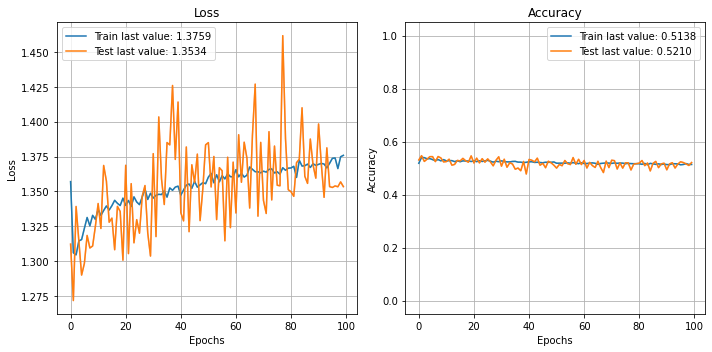

In [32]:
plot_history(results_cifar["cnn_amsgrad"].history)

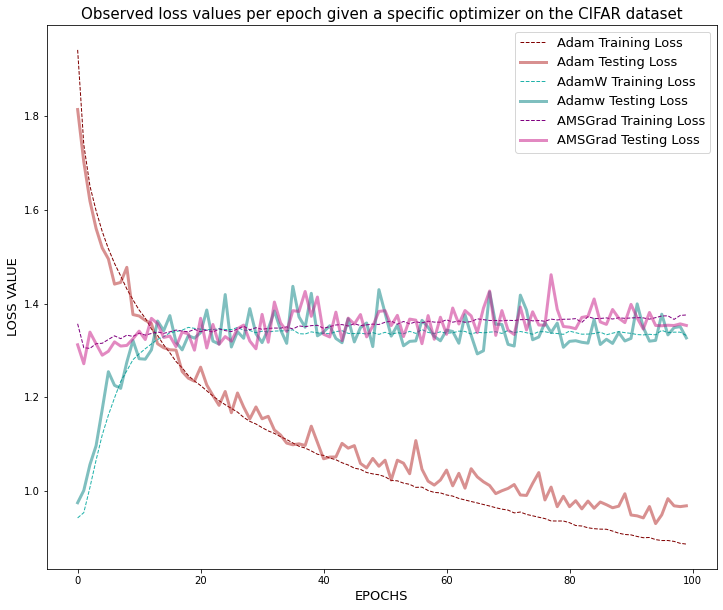

In [33]:
plot_loss("cnn", "CIFAR")

#### 7.4.4 Residual Models

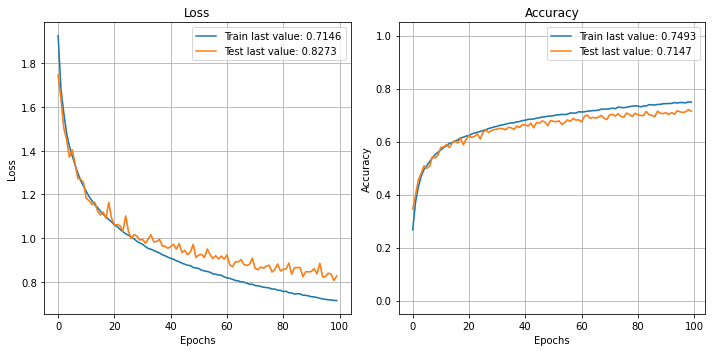

In [35]:
plot_history(results_cifar["resnet_adam"].history)

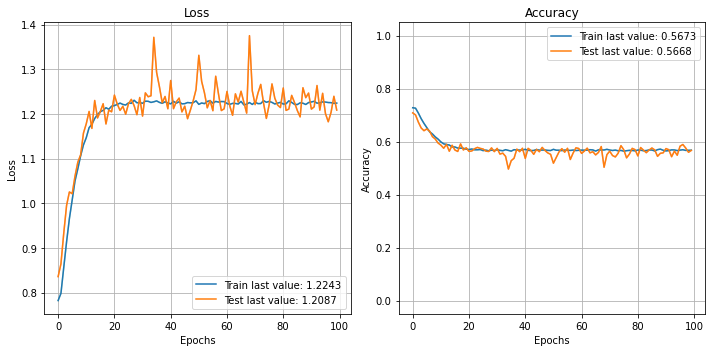

In [36]:
plot_history(results_cifar["resnet_adamw"].history)

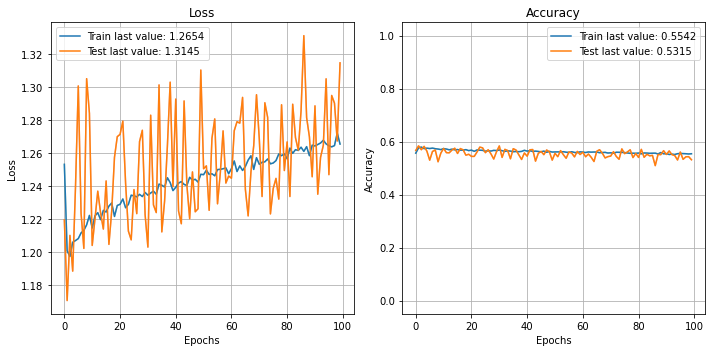

In [37]:
plot_history(results_cifar["resnet_amsgrad"].history)

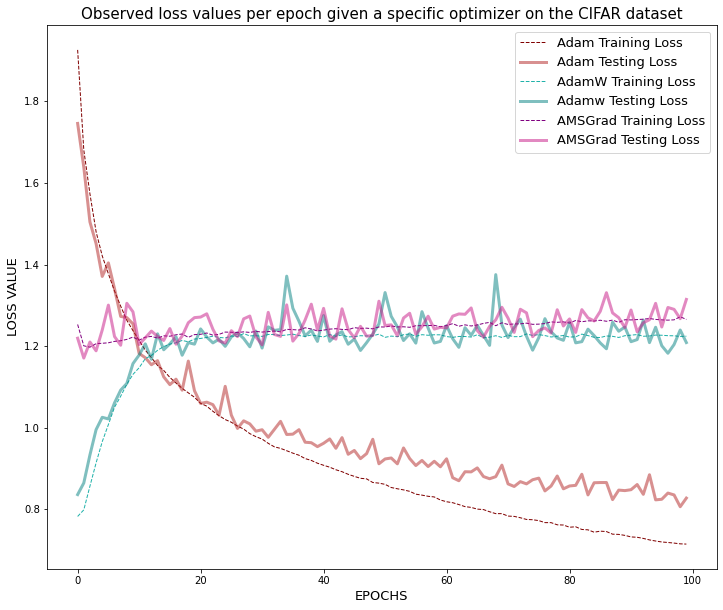

In [38]:
plot_loss("resnet", "CIFAR")

## 8. Expanding to German Road Signs

### 8.1 Importing the dataset

In [9]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [10]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [11]:
# German Road Signs

with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)

sign_x_train, sign_y_train = train_data['features'], train_data['labels']
sign_x_test, sign_y_test = val_data['features'], val_data['labels']

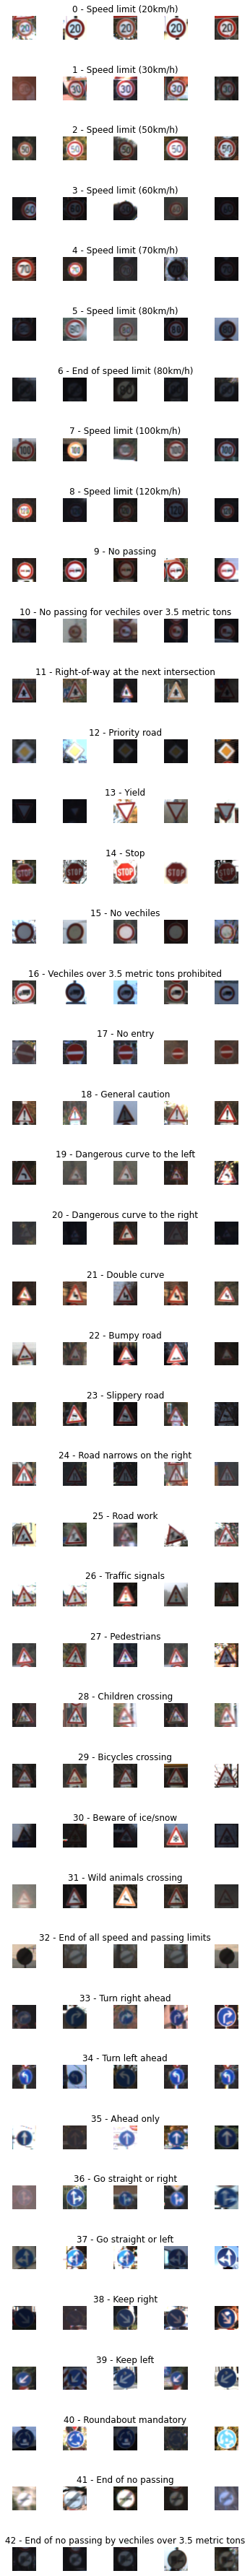

In [12]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
  
num_of_samples=[]
 
cols = 5
num_classes = 43
 
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()
 
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = sign_x_train[sign_y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], 
                         cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + " - " + row["SignName"])
            num_of_samples.append(len(x_selected))

In [13]:
sign_x_train, sign_x_test = normalize(sign_x_train), normalize(sign_x_test)
sign_y_train = one_hot_labels(sign_y_train, 43)
sign_y_test = one_hot_labels(sign_y_test, 43)

## 7.2. Model Declarations

In [14]:
# Global variable declaration

input_shape = (32, 32, 3)
num_classes = 43

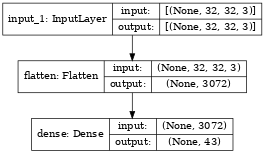

In [15]:
# Declaring Shallow Models
shallow_road = shallow_neural_network(input_shape=input_shape, 
                                      num_classes=num_classes)

plot_model(shallow_road, show_shapes=True, dpi=50)

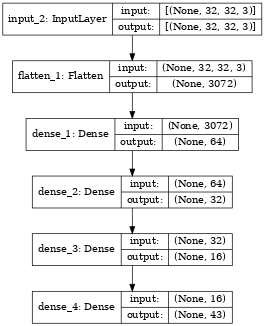

In [16]:
# Declaring Deep (Fully-Connected) Models
dnn_road = deep_neural_network(input_shape=input_shape, 
                               num_classes=num_classes)

plot_model(dnn_road, show_shapes=True, dpi=50)

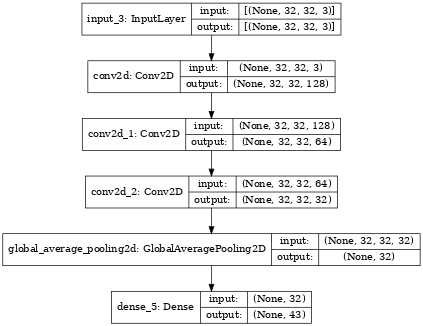

In [17]:
# Declaring Convolutional Models
cnn_road = convolutional_neural_network(input_shape=input_shape, 
                                        num_classes=num_classes)

plot_model(cnn_road, show_shapes=True, dpi=50)

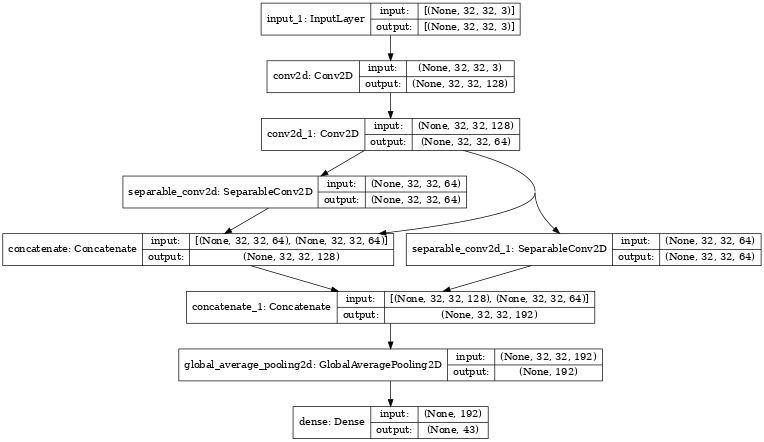

In [15]:
# Declaring ResNet Models
resnet_road = residual_neural_network(input_shape=input_shape, 
                                      num_classes=num_classes)

plot_model(resnet_road, show_shapes=True, dpi=50)

### 7.3 Computing the Results

In [16]:
# Global Variable Declaration
epochs = 100
batch_size = 32
loss = "categorical_crossentropy"
metrics = ["accuracy"]

# Generic learning rate and weight decay for AdamW and AMSgrad
lr=0.001
beta_1=0.9
beta_2=0.999
weight_decay=1e-4
epsilon=1e-8
decay=0.

optimizers = [("adam", Adam()), 
              ("adamw", AdamW(lr=lr, beta_1=beta_1, beta_2=beta_2, 
                              weight_decay=weight_decay, epsilon=epsilon, 
                              decay=decay)), 
              ("amsgrad", AdamW(lr=lr, beta_1=beta_1, beta_2=beta_2, 
                                weight_decay=weight_decay, epsilon=epsilon, 
                                decay=decay,
                                amsgrad=True))]

results_road = {}

#### 7.3.1. Computing loss results for shallow models

In [24]:
for name, optimizer in optimizers:
    print(f"\n\nComputing losses for Shallow NN with optimizer {name}")
    m = compile_fit(shallow_road, 
                    sign_x_train, sign_y_train, 
                    sign_x_test, sign_y_test,
                    optimizer, loss, metrics,
                    epochs, batch_size)
    results_road[f"shallow_{name}"]=m



Computing losses for Shallow NN with optimizer adam


Computing losses for Shallow NN with optimizer adamw


Computing losses for Shallow NN with optimizer amsgrad


#### 7.3.2. Computing loss results for deep (fully-connected) models

In [30]:
for name, optimizer in optimizers:
    print(f"\n\nComputing losses for Deep NN with optimizer {name}")
    m = compile_fit(dnn_road, 
                    sign_x_train, sign_y_train, 
                    sign_x_test, sign_y_test,
                    optimizer, loss, metrics,
                    epochs, batch_size)
    results_road[f"deep_{name}"]=m



Computing losses for Deep NN with optimizer adam


Computing losses for Deep NN with optimizer adamw


Computing losses for Deep NN with optimizer amsgrad


#### 7.3.3. Computing loss results for convolutional models

In [20]:
for name, optimizer in optimizers:
    print(f"\n\nComputing losses for CNN with optimizer {name}")
    m = compile_fit(cnn_road, 
                    sign_x_train, sign_y_train, 
                    sign_x_test, sign_y_test,
                    optimizer, loss, metrics,
                    epochs, batch_size)
    results_road[f"cnn_{name}"]=m



Computing losses for CNN with optimizer adam


Computing losses for CNN with optimizer adamw


Computing losses for CNN with optimizer amsgrad


#### 7.3.4. Computing loss results for residual models

In [17]:
for name, optimizer in optimizers:
    print(f"\n\nComputing losses for ResNet with optimizer {name}")
    m = compile_fit(resnet_road, 
                    sign_x_train, sign_y_train, 
                    sign_x_test, sign_y_test,
                    optimizer, loss, metrics,
                    epochs, batch_size)
    results_road[f"resnet_{name}"]=m



Computing losses for ResNet with optimizer adam


Computing losses for ResNet with optimizer adamw


Computing losses for ResNet with optimizer amsgrad


### 7.4. Result Visualizations

#### 7.4.1 Shallow Models

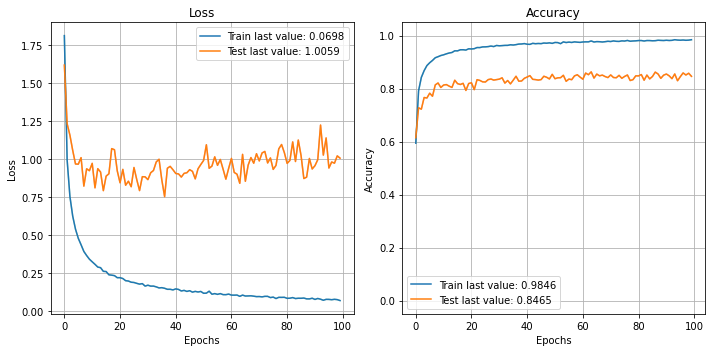

In [25]:
plot_history(results_road["shallow_adam"].history)

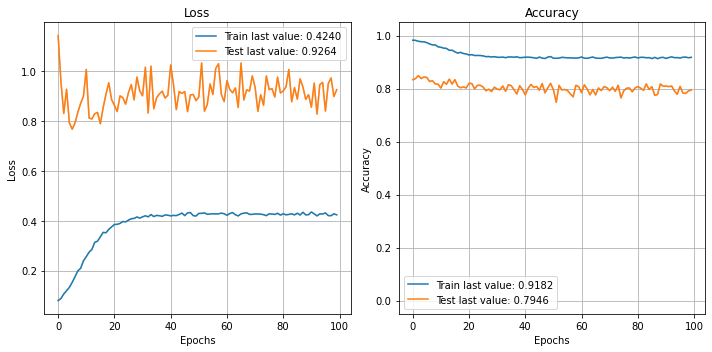

In [26]:
plot_history(results_road["shallow_adamw"].history)

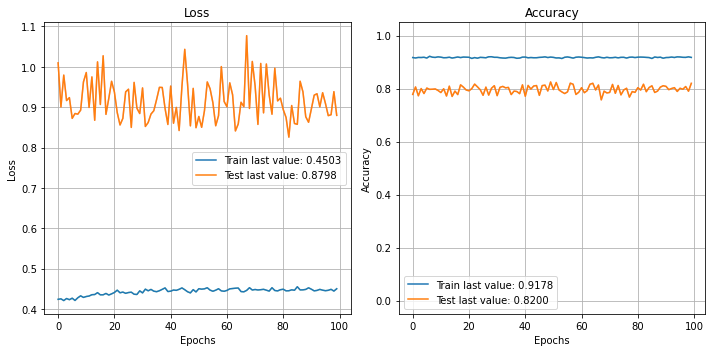

In [27]:
plot_history(results_road["shallow_amsgrad"].history)

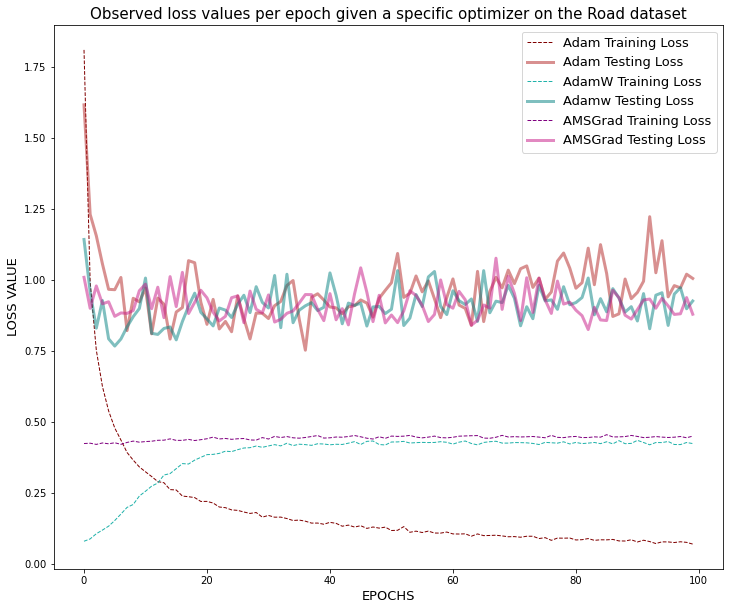

In [28]:
plot_loss("shallow", "Road")

#### 7.4.2 Deep (Fully-Connected) Models

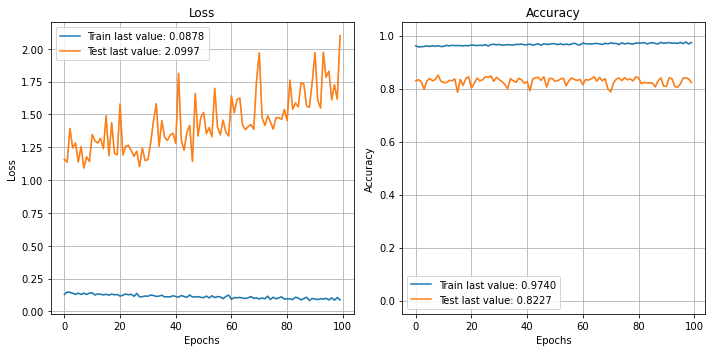

In [31]:
plot_history(results_road["deep_adam"].history)

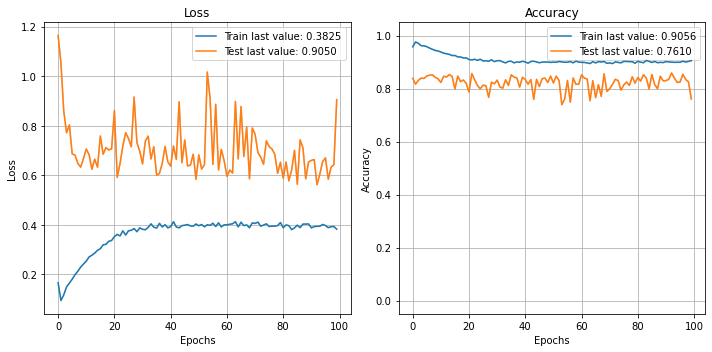

In [32]:
plot_history(results_road["deep_adamw"].history)

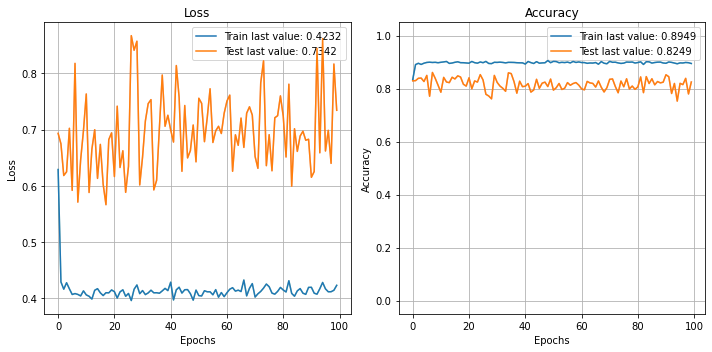

In [33]:
plot_history(results_road["deep_amsgrad"].history)

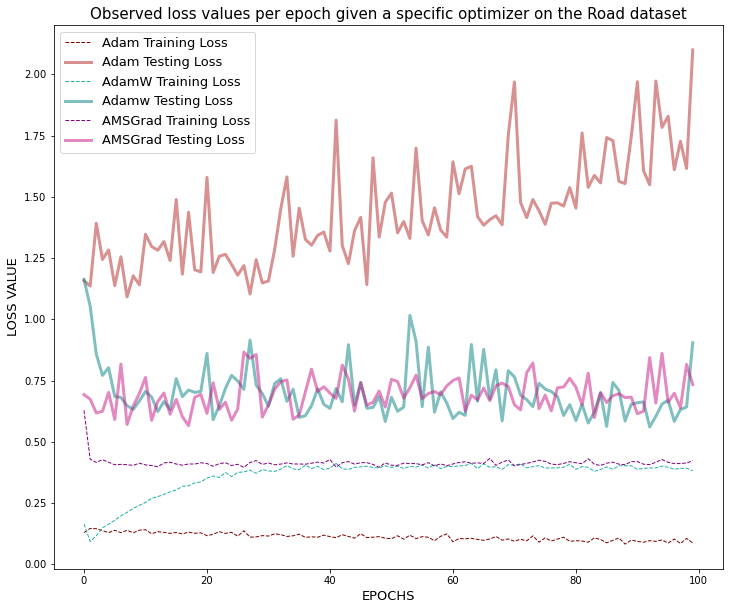

In [34]:
plot_loss("deep", "Road")

#### 7.4.3 Convolutional Models

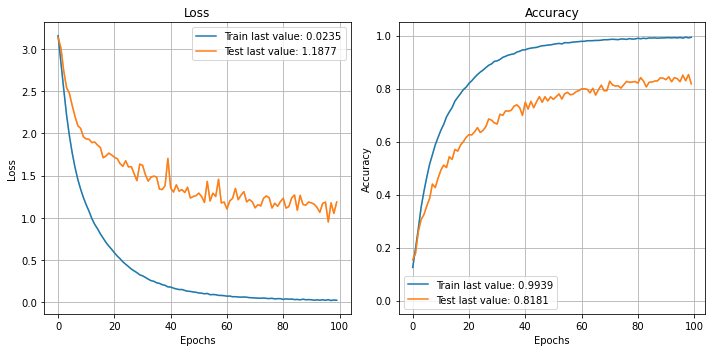

In [21]:
plot_history(results_road["cnn_adam"].history)

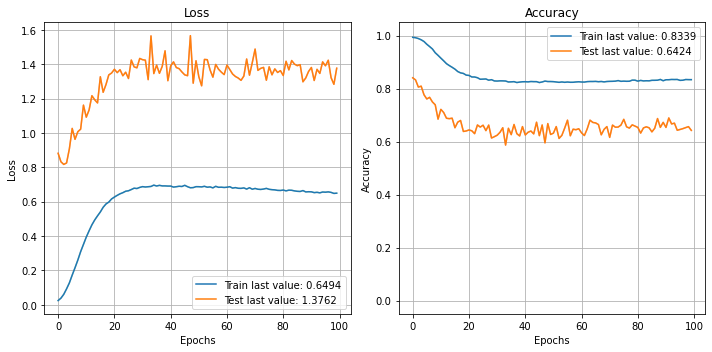

In [22]:
plot_history(results_road["cnn_adamw"].history)

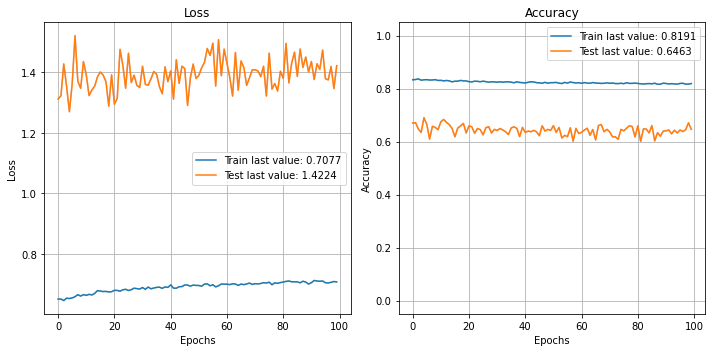

In [23]:
plot_history(results_road["cnn_amsgrad"].history)

In [24]:
plot_loss("cnn", "Road")

#### 7.4.4 Residual Models

In [18]:
plot_history(results_road["resnet_adam"].history)

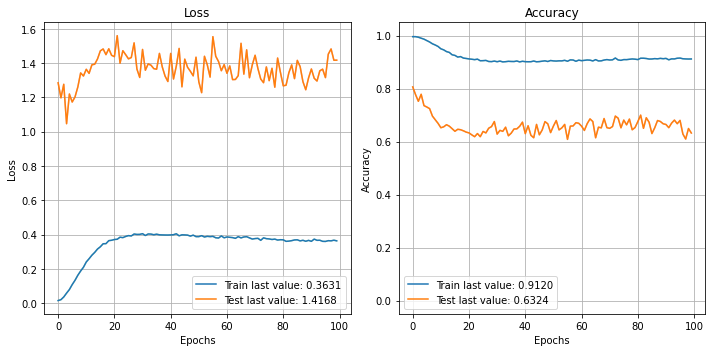

In [19]:
plot_history(results_road["resnet_adamw"].history)

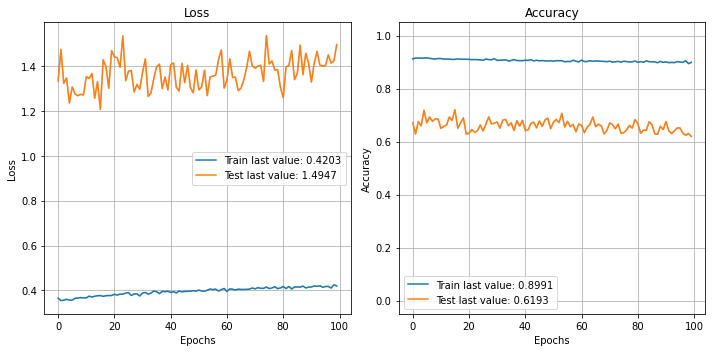

In [20]:
plot_history(results_road["resnet_amsgrad"].history)

In [21]:
plot_loss("resnet", "Road")